In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import os
import zstandard as zstd
import io
import random
import pickle
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
conda install zstandard

Channels:
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
def process_csv_files(directory, ticker):
    """
    Convert input csv to dataframes and prepare to process through trading signal.

    Params:
    directory (String): Name of directory that contains list of csv files.

    Returns:
    return (list[DataFrame]): List of pandas DataFrames, one for each trading day.
    """
    
    # Directory containing the CSV files
    
    ret = []
    i = 1
    # Loop through all files in the directory and convert .zst csv to df
    for filename in os.listdir(directory):
        
        if filename.endswith('.zst'):
            filepath = os.path.join(directory, filename)

            try:
                # Open the compressed file in binary mode
                with open(filepath, 'rb') as compressed_file:
                    # Initialize the decompressor
                    dctx = zstd.ZstdDecompressor()
                    
                    # Decompress the file into an in-memory buffer
                    with dctx.stream_reader(compressed_file) as decompressed_stream:
                        text_stream = io.TextIOWrapper(decompressed_stream, encoding='utf-8')
                        print(f"Processing {filename}\n")
                        # Read the decompressed data into a pandas DataFrame
                        df = pd.read_csv(text_stream, parse_dates=['ts_recv', 'ts_event'])
                        print(str(i) + ' read file')
                        df.to_pickle(os.path.join(directory,"day_" + str(i) + ".pkl"))
                        print(str(i) + ' saved file as pickle')
                        i +=1
                        print(f"Processed {filename}\n")
                    
            except Exception as e:
                print(f"Error processing {filename}\n")
                print(e)
                continue
                
            
            
    return 0

In [3]:
def process_csv_files_uncompressed(directory, ticker):
    """
    Convert input csv to dataframes and prepare to process through trading signal.

    Params:
    directory (String): Name of directory that contains list of csv files.

    Returns:
    return (list[DataFrame]): List of pandas DataFrames, one for each trading day.
    """
    
    # Directory containing the CSV files
    
    ret = []
    i = 1
    # Loop through all files in the directory and convert .zst csv to df
    for filename in os.listdir(directory):
        
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)

            try:
                print(f"Processing {filename}\n")
                # Read the decompressed data into a pandas DataFrame
                df = pd.read_csv(filepath, parse_dates=['ts_recv', 'ts_event'])
                print(str(i) + ' read file')
                df.to_pickle(os.path.join(directory,"day_" + str(i) + ".pkl"))
                print(str(i) + ' saved file as pickle')
                i +=1
                print(f"Processed {filename}\n")
                    
            except Exception as e:
                print(f"Error processing {filename}\n")
                print(e)
                continue
                
            
            
    return 0

In [68]:
dfs = process_csv_files('final-dir', 'ANF')

Processing xnas-itch-20240805.mbp-10.csv.zst

1 read file
1 saved file as pickle
Processed xnas-itch-20240805.mbp-10.csv.zst

Processing xnas-itch-20240812.mbp-10.csv.zst

2 read file
2 saved file as pickle
Processed xnas-itch-20240812.mbp-10.csv.zst

Processing xnas-itch-20240823.mbp-10.csv.zst

3 read file
3 saved file as pickle
Processed xnas-itch-20240823.mbp-10.csv.zst

Processing xnas-itch-20240822.mbp-10.csv.zst

4 read file
4 saved file as pickle
Processed xnas-itch-20240822.mbp-10.csv.zst

Processing xnas-itch-20240813.mbp-10.csv.zst

5 read file
5 saved file as pickle
Processed xnas-itch-20240813.mbp-10.csv.zst

Processing xnas-itch-20240830.mbp-10.csv.zst

6 read file
6 saved file as pickle
Processed xnas-itch-20240830.mbp-10.csv.zst

Processing xnas-itch-20240801.mbp-10.csv.zst

7 read file
7 saved file as pickle
Processed xnas-itch-20240801.mbp-10.csv.zst

Processing xnas-itch-20240807.mbp-10.csv.zst

8 read file
8 saved file as pickle
Processed xnas-itch-20240807.mbp-10.c

In [4]:
def moving_average_signal(df, short_window, long_window, b,delay=0):
    """
    Generate trading signals based on moving average cross-over strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating MA signal with delay {delay}')
    # Create midprice column (average of bid and ask prices)
    mid_price = (df['bid_px_00'] + df['ask_px_00']) / 2
    
    # Calculate short-term and long-term moving averages
    short_ma = mid_price.rolling(window=short_window).mean()
    long_ma = mid_price.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal

def momentum_in_price_signal(df, short_window, long_window, b,delay=0):
    """
    Generate trading signals based on momentum in price strategy.

    Params:
    prices (Series): asset prices
    short_window (int): Window size for the short-term moving average
    long_window (int): Window size for the long-term moving average
    b (int): Bandwidth parameter that determines the buy/sell thresholds

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating momentum in price signal with delay {delay}')
    # Create midprice column (average of bid and ask prices)
    mid_price = (df['bid_px_00'] + df['ask_px_00']) / 2
    returns = mid_price.pct_change()

    # Calculate short-term and long-term moving averages
    short_ma = returns.rolling(window=short_window).mean()
    long_ma = returns.rolling(window=long_window).mean()
    
    # Define thresholds
    upper_threshold = (1 + b) * long_ma
    lower_threshold = (1 - b) * long_ma
    
    signal = pd.Series(0, index=df.index)

    # Generate buy signals (+1 where short_ma > upper_threshold)
    signal[short_ma > upper_threshold] = 1
    
    # Generate sell signals (-1 where short_ma < lower_threshold)
    signal[short_ma < lower_threshold] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal

def spread_order_imbalance(df, short_window,long_window, delay=0):
    """
    Generate trading signals based on spread order imbalance strategy.

    Params:
    df (DataFrame): DataFrame containing bid and ask prices and volumes
    delay (int): Number of periods to delay the signal

    Return:
    return (Series): Series with trading signals (+1 for buy, -1 for sell, 0 for hold)
    """
    print(f'Generating spread order imbalance signal with delay {delay}')
    # Calculate spread
    spread = df['ask_px_00'] - df['bid_px_00']

    # Calculate short-term and long-term moving averages of spread
    spread_ma_short= spread.rolling(window=short_window).mean()
    spread_ma_long = spread.rolling(window=long_window).mean()

    
    # Calculate order imbalance
    order_imbalance = (df['ask_sz_00'] - df['bid_sz_00']) / (df['ask_sz_00'] + df['bid_sz_00'])
    
    # Generate signal based on order imbalance and spread
    signal = pd.Series(0, index=df.index)
    signal[(spread_ma_short<spread_ma_long)&(order_imbalance > 0.5)] = 1
    signal[(spread_ma_short>spread_ma_long)&(order_imbalance < -0.5)] = -1

    # Delay signal by 'delay' periods to account for trading frictions
    signal = signal.shift(delay).fillna(0)

    #Set signal to 0 at the end of the day to ensure no overnight positions
    signal[df.index.time > pd.to_datetime('19:55').time()] = 0

    return signal





In [6]:
def execute_trading_signal(df, signal, order_size=1_000_000):
    """
    Execute the trading signal based on the available order book depth and calculate actual P&L.
    
    Params:
    bbo_df (DataFrame): DataFrame containing the order book and signals for each day.
    signal (Series): Series containing the generated trading signals.
    order_size (float): Size of the order for each trade (default $1M).
    
    Returns:
    DataFrame: Updated DataFrame with calculated returns.
    """

    # Initialize position and return
    position = 0
    shares_held = 0
    bbo_df = df.copy()
    bbo_df['return'] = 0

    # Process MPB-10 data to get 3-level deep order book
    #bids, asks = process_mpb10_data(bbo_df)
    bids = bbo_df[['bid_px_00', 'bid_sz_00', 'bid_px_01', 'bid_sz_01', 'bid_px_02', 'bid_sz_02']].copy()
    asks = bbo_df[['ask_px_00', 'ask_sz_00', 'ask_px_01', 'ask_sz_01', 'ask_px_02', 'ask_sz_02']].copy()

    # Track the first signal to open a position, then exit when the signal reverses
    open_position = False
    
    for i in signal.index:
        current_signal = signal.loc[i]
        
        # Buy logic: first time signal turns +1 and we don't have an open position
        if current_signal == 1 and (not open_position or shares_held < 0):
            shares_bought = 0
            investment = 0

            # Buy up to 3 levels of the ask side until $1M is spent
            for level in range(3):
                ask_price = asks.loc[i, f'ask_px_0{level}']
                ask_size = asks.loc[i, f'ask_sz_0{level}']
                level_investment = min(order_size - shares_held*ask_price - investment, ask_price * ask_size)

                # Calculate number of shares to buy
                level_shares = level_investment / ask_price
                shares_bought += level_shares
                investment += level_investment
                
                if investment >= order_size:
                    break  # Exit loop when $1M investment is reached
            
            position += investment
            shares_held += shares_bought
            open_position = True  # Mark that position is open
            
            # Mark the negative cash flow from buying
            bbo_df.loc[i, 'return'] = -investment
            
        # Sell logic: first time signal turns -1 and we don't have an open position
        elif current_signal == -1 and (not open_position or shares_held > 0):
            shares_sold = 0
            revenue = 0

            # Sell up to 3 levels of the bid side, until $1M worth of shares are sold
            for level in range(3):
                bid_price = bids.loc[i, f'bid_px_0{level}']
                bid_size = bids.loc[i, f'bid_sz_0{level}']
                level_revenue = min(order_size + bid_price*shares_held - revenue, bid_price * bid_size)
                level_shares = level_revenue / bid_price

                shares_sold += level_shares
                revenue += level_revenue
                
                if revenue >= order_size:
                    break
            
            position -= revenue
            shares_held -= shares_sold
            open_position = True

            # Mark the positive cash flow from selling
            bbo_df.loc[i, 'return'] = revenue

        
        # Exit logic: signal turns 0 and we have an open position
        elif current_signal == 0 and open_position:
            # Liquidate the position by settling the open trade
            if shares_held > 0:
                # Sell all shares at the bid price
                ask_price = asks.loc[i, 'ask_px_00']
                ask_size = asks.loc[i, 'ask_sz_00']
                sell_qty = min(shares_held, ask_size)
                revenue = sell_qty * ask_price
                position -= revenue
                shares_held -= sell_qty

                if(shares_held == 0):
                    open_position = False

                # Mark the positive cash flow from selling
                bbo_df.loc[i, 'return'] = revenue

            elif shares_held < 0:
                # Buy back all shares at the ask price
                bid_price = bids.loc[i, 'bid_px_00']
                bid_size = bids.loc[i, 'bid_sz_00']
                buy_qty = min(-shares_held, bid_size)
                investment = buy_qty * bid_price
                position += investment
                shares_held += buy_qty
                if(shares_held == 0):
                    open_position = False

                # Mark the negative cash flow from buying
                bbo_df.loc[i, 'return'] = -investment

    # Scale the cumulative return
    bbo_df['cumulative_return'] = (bbo_df['return']).cumsum()
    bbo_df['scaled_return'] = bbo_df['cumulative_return'] / 1_000_000
    
    return bbo_df


In [73]:
def signal_and_trade_to_dataframe(ticker, directory, moving_average_params, momentum_params, spread_order_params):
    """
    Function to generate signals, execute trades, and calculate returns using different parameter sets and delays for each signal type.
    
    Parameters:
    ticker (str): The ticker symbol to filter the data.
    directory (str): The directory containing the .pkl files with the data.
    moving_average_params (list of tuples): List of parameter sets for the moving average signal.
    momentum_params (list of tuples): List of parameter sets for the momentum signal.
    spread_order_params (list of tuples): List of parameter sets for the spread order imbalance signal.

    Returns:
    DataFrame: A DataFrame with cumulative returns for each signal and parameter combination for each day, including delay.
    """
    
    # Create a list to store results for each signal-parameter combination, day, and delay
    results = []

    # Define the delays
    delays = [0, 1, 10]

    # Process data for the first 3 trading days only
    for day in tqdm(range(1, 23)):  # Process only 3 days
        filename = 'day_' + str(day) + '.pkl'
        filepath = os.path.join(directory, filename)
        
        # Load the .pkl file
        with open(filepath, 'rb') as file:
            df = pickle.load(file)
            
        print(f'Successfully loaded {filename}. Processing as DataFrame.')
        
        # Filter and resample data
        if 'ts_event' in df.columns:
            df = df.set_index('ts_event')
                    
        bbo_df = df.between_time('13:40', '19:55', inclusive='left')
        tkr_df = bbo_df[bbo_df['symbol'] == ticker].resample('100ms').last().ffill()

        print(f'Successfully cleaned and processed DataFrame. Sending to generate returns.')

        # Loop through the delays
        for delay in delays:
            # Process Moving Average signals
            for params in moving_average_params:
                signal = moving_average_signal(tkr_df, *params, delay=delay)  # Pass the delay
                returns = execute_trading_signal(tkr_df, signal)
                cumulative_return = returns["cumulative_return"].tail(1).values[0]
                results.append({'signal': 'moving_average', 'params': params, 'day': day, 'delay': delay, 'cumulative_return': cumulative_return})

            # Process Momentum signals
            for params in momentum_params:
                signal = momentum_in_price_signal(tkr_df, *params, delay=delay)  # Pass the delay
                returns = execute_trading_signal(tkr_df, signal)
                cumulative_return = returns["cumulative_return"].tail(1).values[0]
                results.append({'signal': 'momentum', 'params': params, 'day': day, 'delay': delay, 'cumulative_return': cumulative_return})

            # Process Spread Order Imbalance signals
            for params in spread_order_params:
                signal = spread_order_imbalance(tkr_df, *params, delay=delay)  # Pass the delay
                returns = execute_trading_signal(tkr_df, signal)
                cumulative_return = returns["cumulative_return"].tail(1).values[0]
                results.append({'signal': 'spread_order_imbalance', 'params': params, 'day': day, 'delay': delay, 'cumulative_return': cumulative_return})

        print(f'Returns successfully generated for {filename}\n')

    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
moving_avg_params = [(300, 1000, 0.002), (500, 2000, 0.0015), (1000, 3000, 0.002)]
momentum_params = [(30, 60, 0.002), (60, 120, 0.003), (100, 200, 0.005)]
spread_order_params = [(200, 500), (300, 700), (500, 1000)]  # Both short and long windows

# Call the function with your ticker and directory
daily_returns = signal_and_trade_to_dataframe('ANF', 'equity-pkl', 
                                 moving_average_params=moving_avg_params, 
                                 momentum_params=momentum_params, 
                                 spread_order_params=spread_order_params)


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Successfully loaded day_1.pkl. Processing as DataFrame.
Successfully cleaned and processed DataFrame. Sending to generate returns.
Generating MA signal with delay 0
Generating MA signal with delay 0
Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating momentum in price signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating spread order imbalance signal with delay 0


In [70]:
daily_returns.to_clipboard()

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results_with_sharpe_vol(df):
    """
    Function to plot the daily cumulative returns, 3-day rolling Sharpe ratio, and 3-day rolling volatility
    for each combination of signal, parameter, and delay.
    
    Parameters:
    df (DataFrame): The DataFrame containing the results for each signal, parameter, day, and delay.
                    Expected columns: ['signal', 'params', 'day', 'delay', 'cumulative_return']
    """
    
    # Group by signal, params, and delay to get unique combinations
    grouped = df.groupby(['signal', 'params', 'delay'])

    # Create subplots for each group
    num_plots = len(grouped)
    fig, axs = plt.subplots((num_plots + 2) // 3, 3, figsize=(18, 24))
    axs = axs.ravel()

    # Iterate over each combination of signal, params, and delay
    for idx, ((signal, params, delay), group) in enumerate(grouped):
        group = group.sort_values(by='day')  # Sort by day to ensure proper plotting

        # Get cumulative returns as a pandas Series
        returns_series = group['cumulative_return'].reset_index(drop=True)

        # Calculate rolling 3-day volatility (standard deviation)
        rolling_volatility = returns_series.rolling(window=3).std()

        # Calculate rolling 3-day Sharpe ratio (assuming risk-free rate = 0)
        rolling_mean_return = returns_series.rolling(window=3).mean()
        rolling_sharpe = rolling_mean_return / rolling_volatility

        # Plot Cumulative Returns
        axs[idx].plot(group['day'], returns_series, label=f'Cumulative Return', marker='o')
        axs[idx].set_title(f'{signal} with params {params} | Delay: {delay}')
        axs[idx].set_xlabel('Day')
        axs[idx].set_ylabel('Cumulative Return')

        # Plot rolling volatility and Sharpe ratio on a secondary axis
        ax2 = axs[idx].twinx()
        ax2.plot(group['day'], rolling_volatility, color='orange', linestyle='--', label='3-day Volatility')
        ax2.plot(group['day'], rolling_sharpe, color='green', linestyle=':', label='3-day Sharpe')
        ax2.set_ylabel('Volatility / Sharpe')

        # Adding legends
        axs[idx].legend(loc='upper left')
        ax2.legend(loc='upper right')
        axs[idx].grid(True)

    # Hide unused subplots
    for i in range(len(grouped), len(axs)):
        fig.delaxes(axs[i])

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage assuming you have a DataFrame `results_df`:
# plot_results_with_sharpe_vol(results_df)


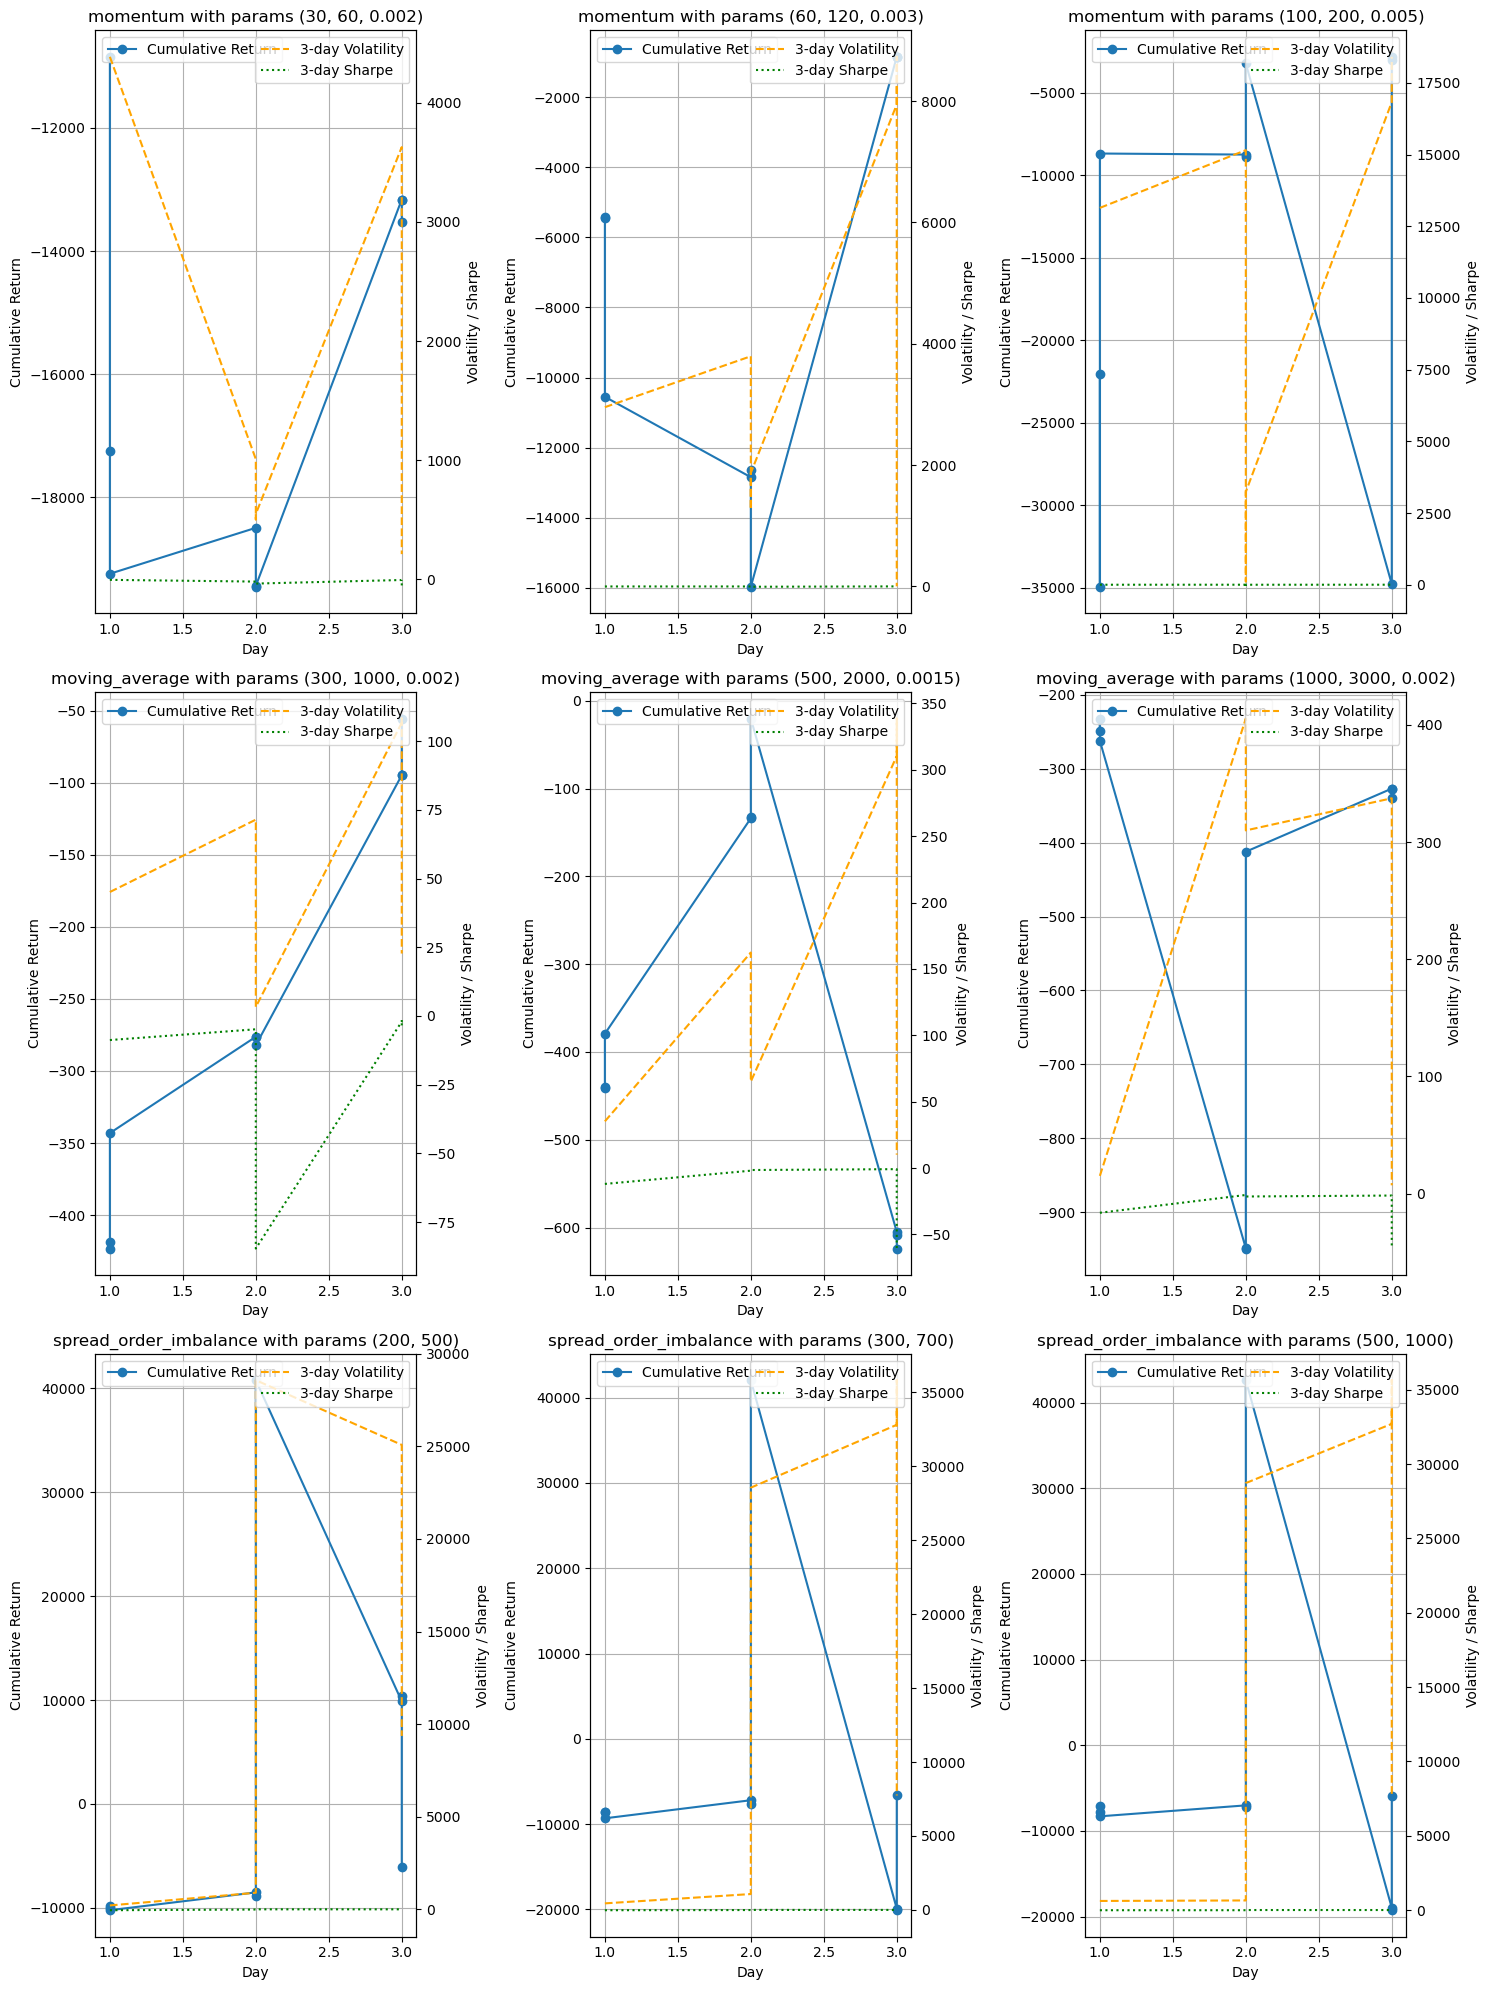

In [72]:
plot_daily_returns_with_params(daily_returns)


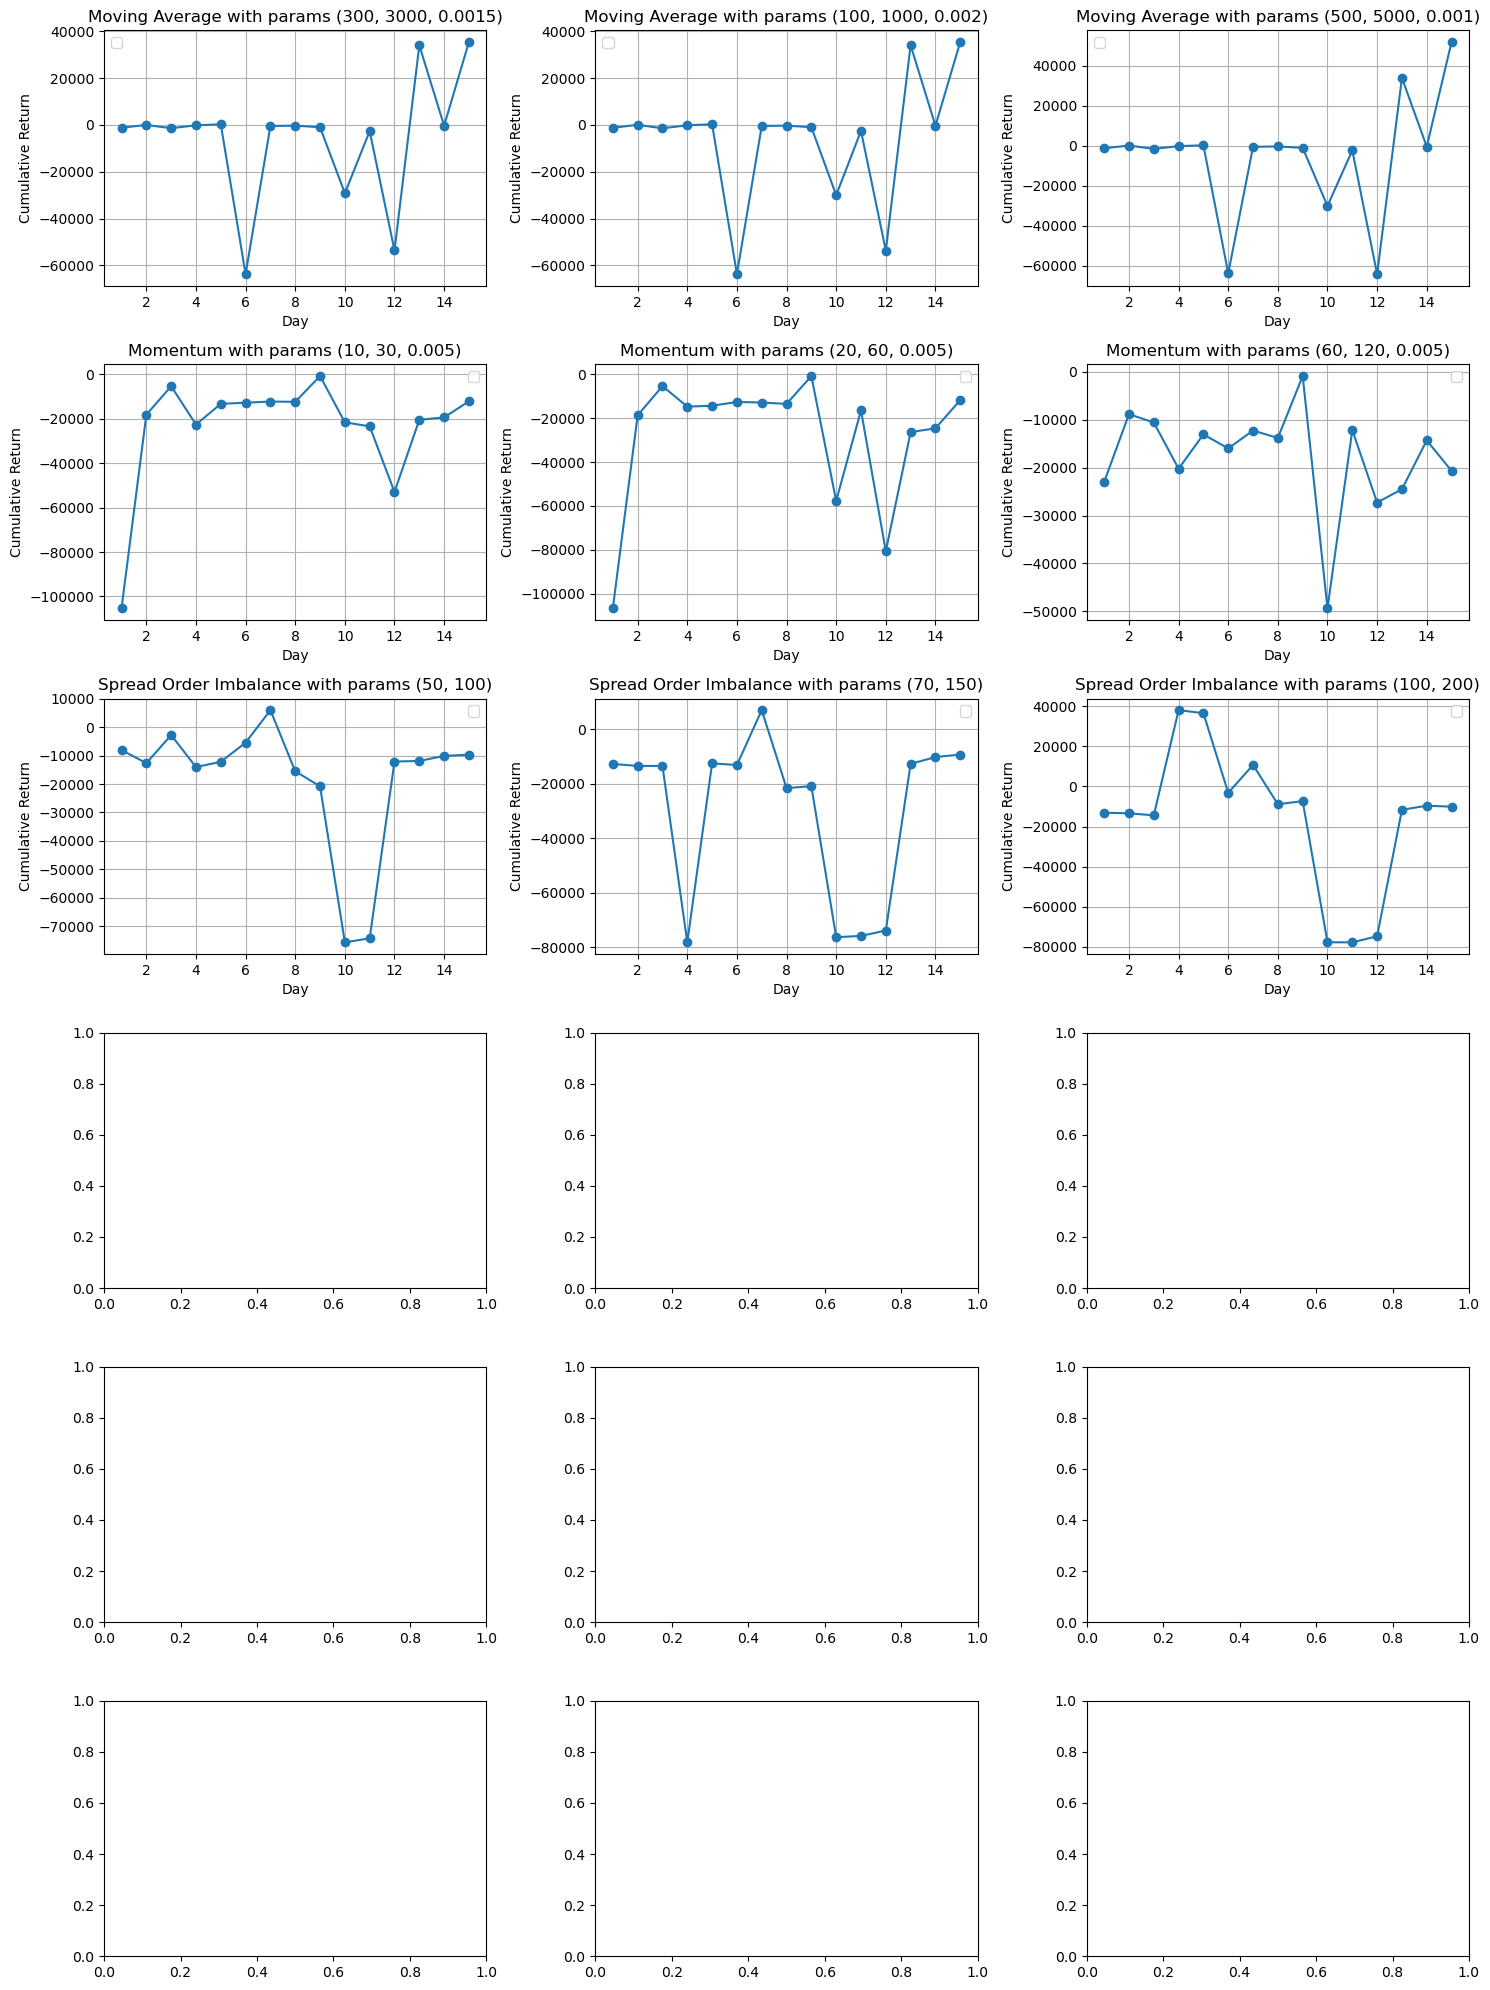

In [38]:
plot_daily_returns_with_params(daily_returns, moving_avg_params, momentum_params, spread_order_params, ['Moving Average', 'Momentum', 'Spread Order Imbalance'])

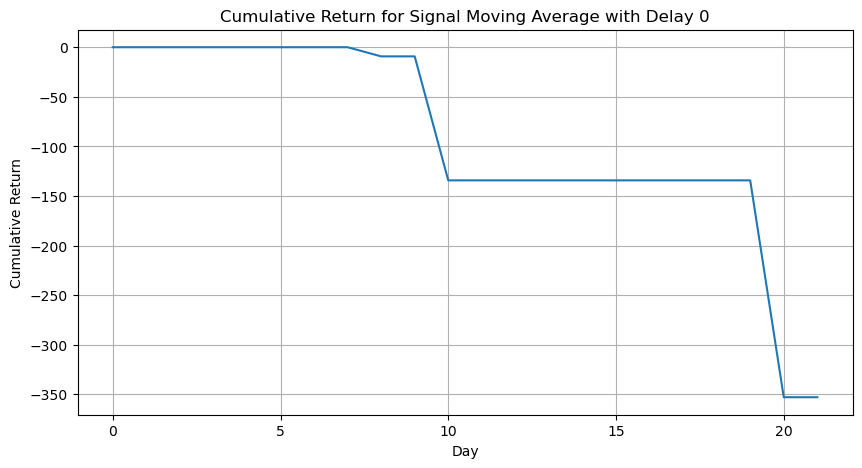

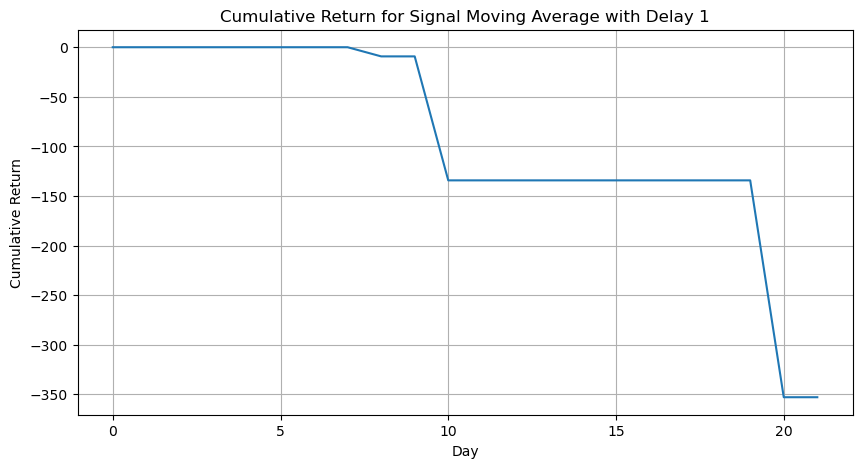

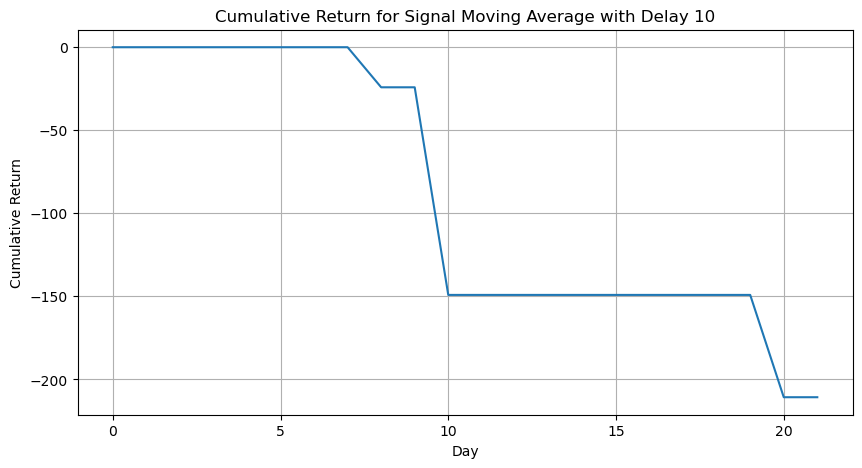

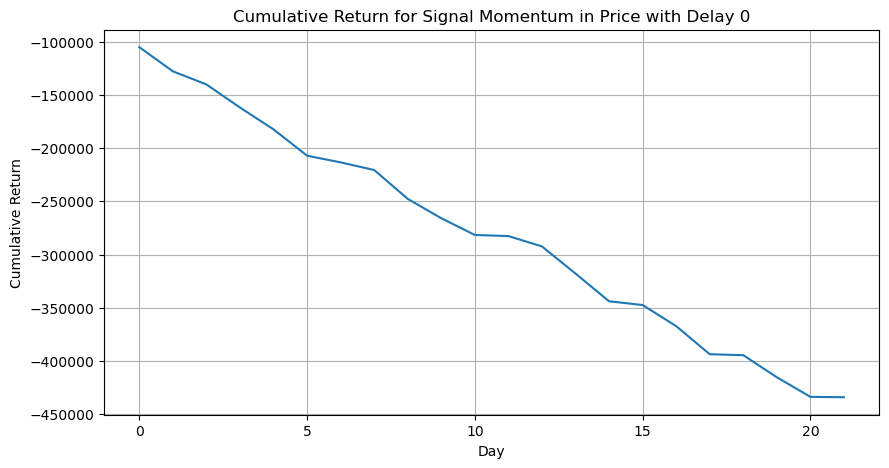

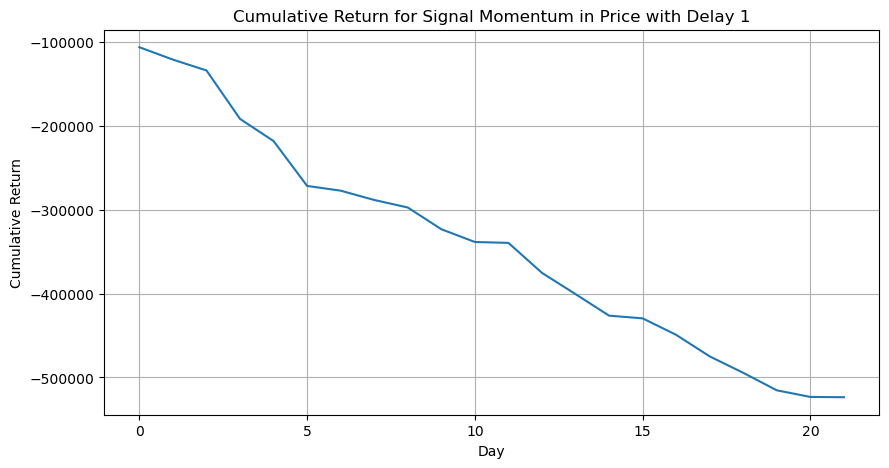

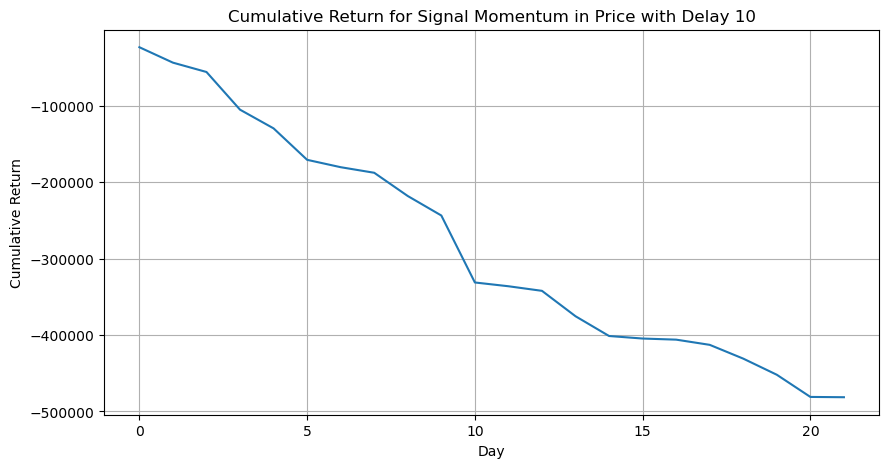

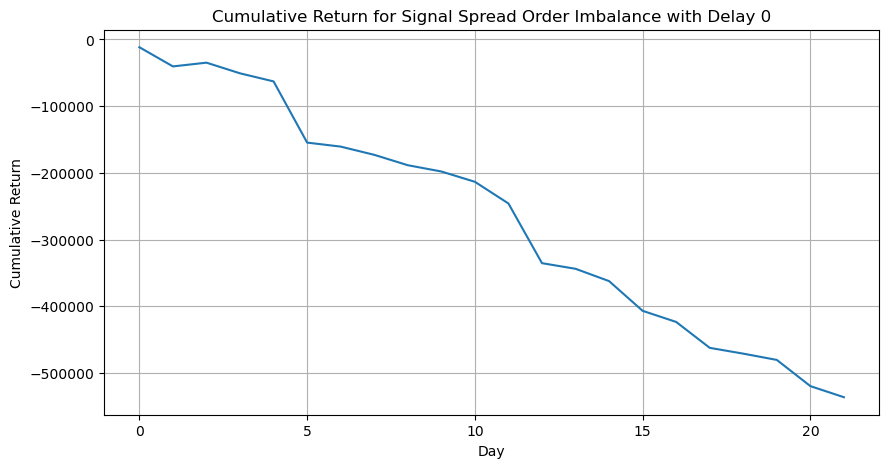

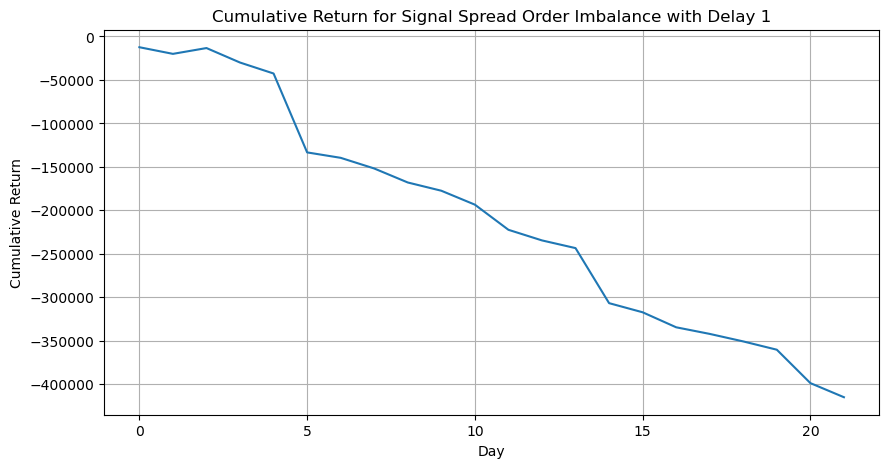

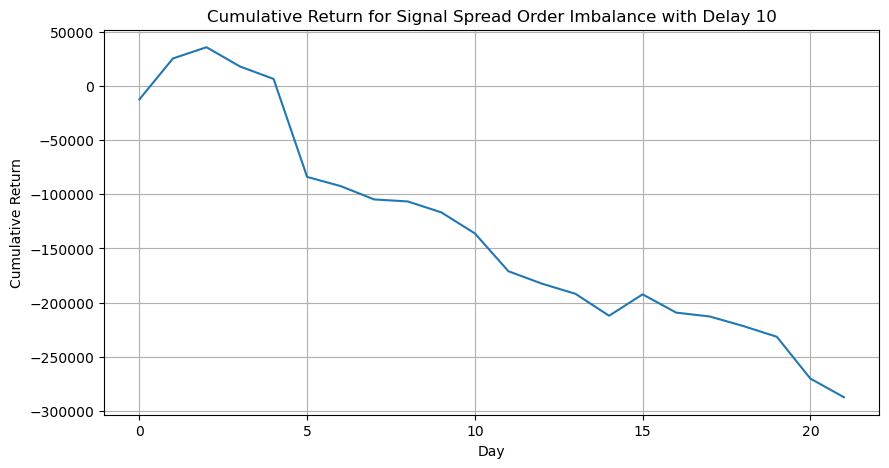

In [9]:
# Iterate through the dictionary df
for key, value in df.items():
    # Convert the list into a pandas Series
    series = pd.Series(value).cumsum()
    delay_param = key[1] if key[1] != '2' else 10
    # Plot the Series
    plt.figure(figsize=(10, 5))
    plt.plot(series)
    delay = int(key[1])
    if key[0] == '0':
        signal = 'Moving Average'
    elif key[0] == '1':
        signal = 'Momentum in Price'
    else:
        signal = 'Spread Order Imbalance'
    plt.title(f'Cumulative Return for Signal {signal} with Delay {delay_param}')
    plt.xlabel('Day')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

In [10]:
df2 = signal_and_trade('NVDA', directory)

  0%|                                                    | 0/22 [00:00<?, ?it/s]

Successfully loaded pkl file. Processing as dataframe.
Successfully cleaned and processed DataFrame. Sending to generate returns.
Generating MA signal with delay 0
Generating momentum in price signal with delay 0
Generating spread order imbalance signal with delay 0
Generating MA signal with delay 1
Generating momentum in price signal with delay 1
Generating spread order imbalance signal with delay 1
Generating MA signal with delay 10
Generating momentum in price signal with delay 10
Generating spread order imbalance signal with delay 10


  0%|                                                    | 0/22 [01:10<?, ?it/s]

Returns sucessfully generated for day_1.pkl 



In [12]:
print(df2)

{'00': [0], '01': [0], '02': [0], '10': [-9890.836059055058], '11': [-19217.343969619862], '12': [-188662.86612957966], '20': [-65130.516158739636], '21': [-132745.77280049073], '22': [-153836.1571937814]}


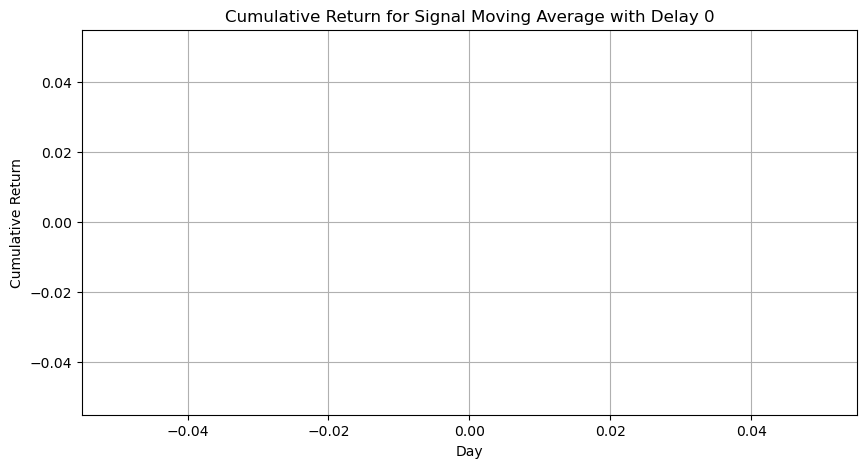

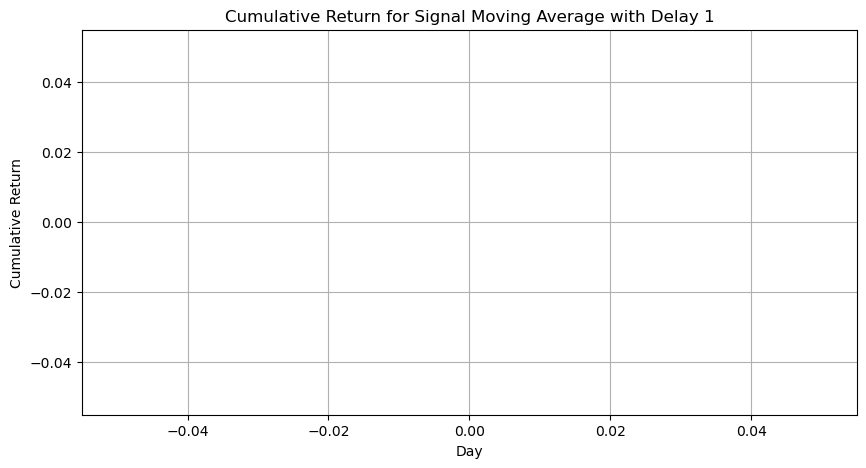

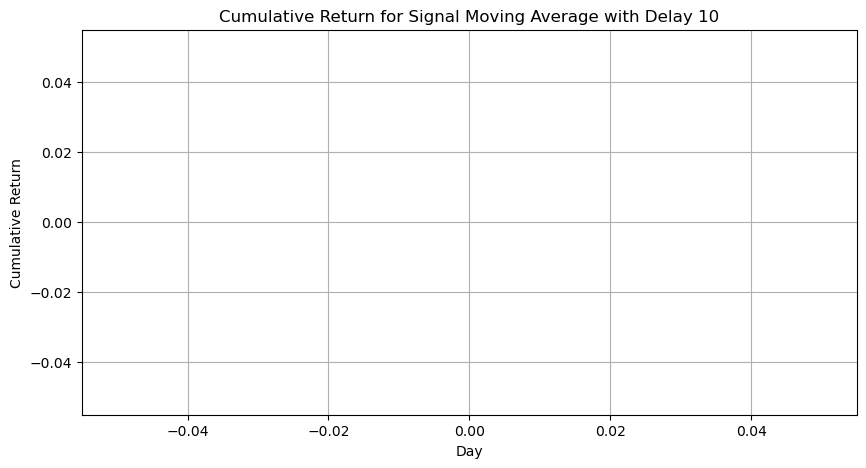

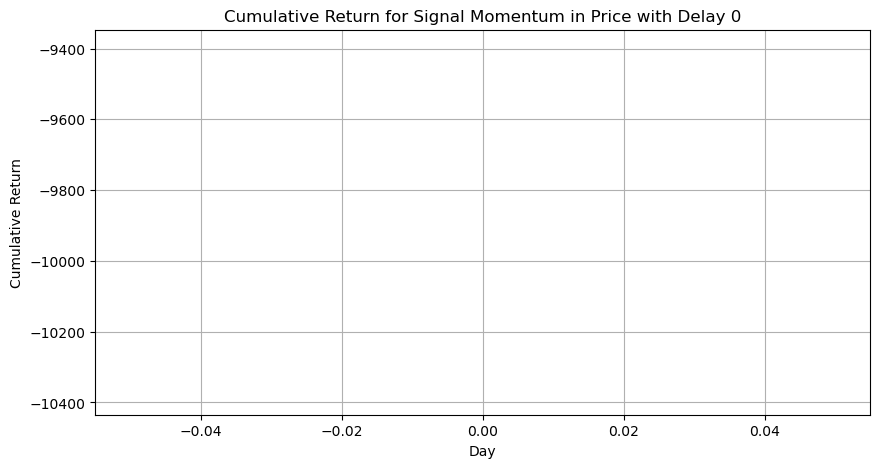

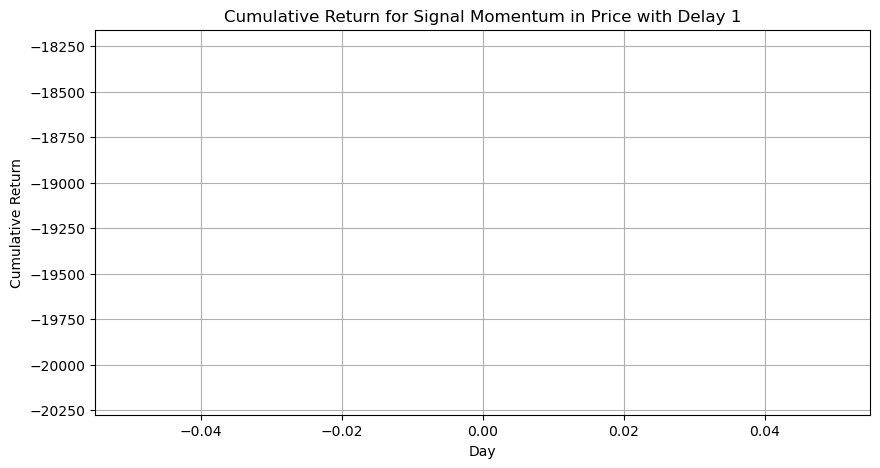

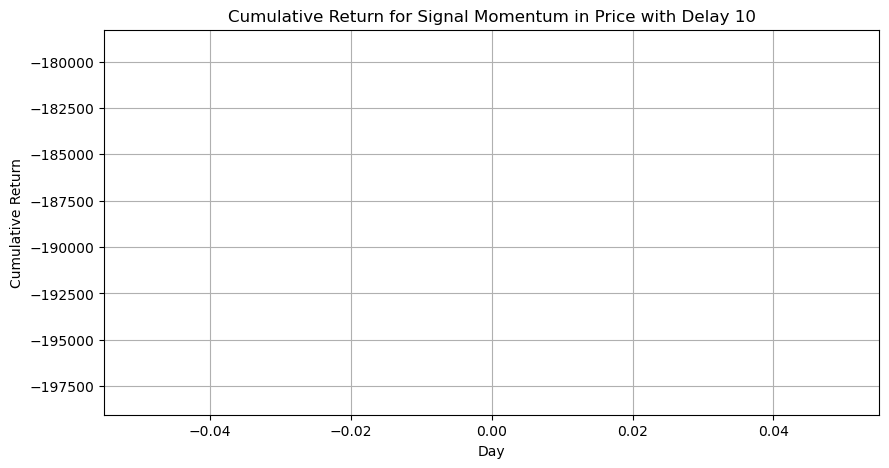

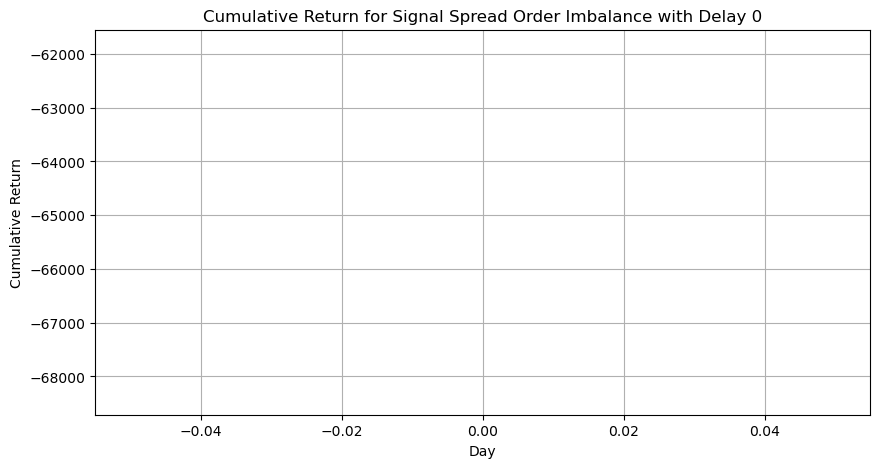

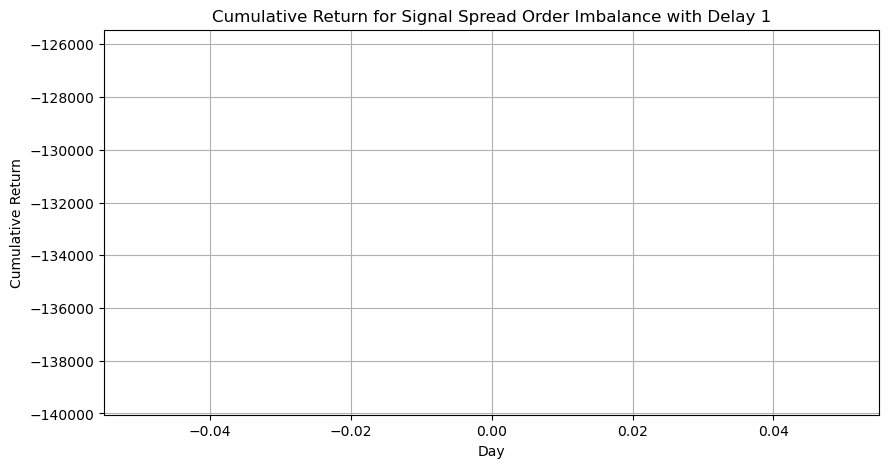

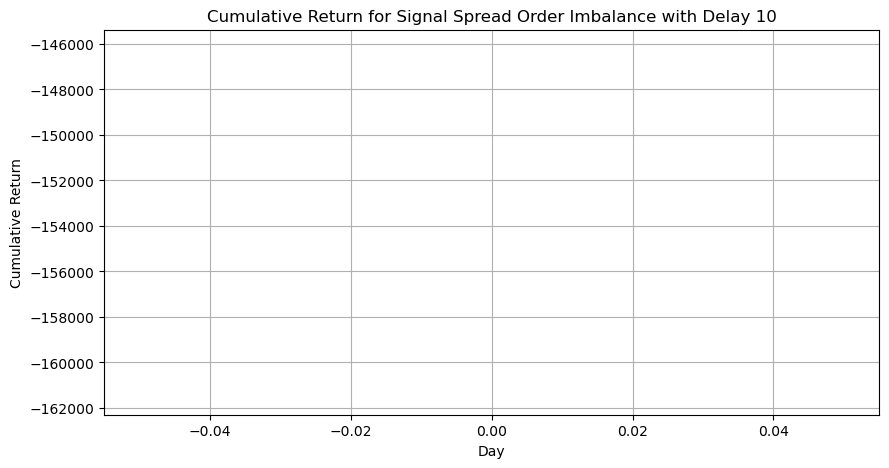

In [11]:
# Iterate through the dictionary df
for key, value in df2.items():
    # Convert the list into a pandas Series
    series = pd.Series(value).cumsum()
    delay_param = key[1] if key[1] != '2' else 10
    # Plot the Series
    plt.figure(figsize=(10, 5))
    plt.plot(series)
    delay = int(key[1])
    if key[0] == '0':
        signal = 'Moving Average'
    elif key[0] == '1':
        signal = 'Momentum in Price'
    else:
        signal = 'Spread Order Imbalance'
    plt.title(f'Cumulative Return for Signal {signal} with Delay {delay_param}')
    plt.xlabel('Day')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

In [ ]:
# signal = moving_average_signal(test, short_window=50, long_window=500, b=0.0001)

# returns = execute_trading_signal(test, signal)

In [ ]:
# theoretical, hopefully this works

returns = []
for df in bbo_dfs_anf:
    ret = execute_trading_signal(df, signal)
    returns.append(ret)